In [1]:
#Imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline
import matplotlib.image as mpimg
import pickle
#%matplotlib inline
import scipy.ndimage
from scipy.signal import find_peaks_cwt

DEBUG = 0

In [2]:
#Define Constants
NUM_COLS = 9
NUM_ROWS = 6

CHESSBOARD_IMG_WIDTH = 1280
CHESSBOARD_IMG_HEIGHT = 720

"""
    Note: These values are obtained from the straight lane
    lines in test_images/straight_lines1.jpg
"""
SRC_BOTTOM_LEFT  =  [220, 710]
SRC_TOP_LEFT     =  [593, 455]
SRC_TOP_RIGHT    =  [694, 455]
SRC_BOTTOM_RIGHT =  [1084, 710]

DST_BOTTOM_LEFT  = [340, 710]
DST_TOP_LEFT     = [340, 0]
DST_TOP_RIGHT    = [910, 0]
DST_BOTTOM_RIGHT = [910, 710]

WINDOW_SIZE = 50
NUM_PATCHES = 10

""" 
    According to standards, the image should cover 
    30meters along the road and 3.7meters along the width.
"""
HEIGHT_IN_MTS = 30
WIDTH_IN_MTS = 3.7

#Mininum number of points for fitting the polynomial curve.
MIN_POINTS = 5

#Threshold for difference of coefficient values, between successive frames. 
COEFFS_DIFFS = 0.0005

calc_calib_params = 0

#Change in contour
SHAPE_THRESH = 0.05

In [3]:
"""
   STEP 1: COMPUTATION OF CAMERA CALIBRATION MATRIX AND DISTORTION COEFFICIENTS
           UNDISTORT THE IMAGES
"""

"""
   Get the object points and image points of the chessboard inner
   corners, using the chessboard calibration images. These points
   are used for calculating the distortion coefficients of the
   camera.
"""
def get_obj_img_points():
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((NUM_ROWS*NUM_COLS,3), np.float32)
    objp[:,:2] = np.mgrid[0:NUM_COLS, 0:NUM_ROWS].T.reshape(-1,2)

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        img_size = (img.shape[1], img.shape[0])
                      
        img_orig = np.copy(img)
       
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (NUM_COLS,NUM_ROWS), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)       
        
    return objpoints, imgpoints
    
    
"""
   Calculate the camera calibration parameters,
   namely, distortion coefficients, projection
   matrix.
"""
def calculate_cam_calib_params(objpoints, imgpoints):
    img_size = (CHESSBOARD_IMG_WIDTH, CHESSBOARD_IMG_HEIGHT)
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                       imgpoints,
                                                       img_size,
                                                       None,None)
    
    return ret, mtx, dist, rvecs, tvecs   

"""
    Fetch the camera calibration parameters, calcluated in
    calculate_cam_calib_params() and stored in CalibrationParams.p
"""
def fetch_cam_calib_params():
    print('Loading data from pickle file...')
    try:
        data_file = 'CalibrationParams.p'
        with open(data_file, mode='rb') as f:
            data = pickle.load(f)
        mtx  = data['mtx'] 
        dist = data['dist']
    except Exception as e:
        print('Unable to save data to', data_file, ':', e)
        raise
    print('Data loaded from pickle file.')   
    
    return mtx, dist        

In [4]:
"""
    Calculate Camera Calibration parameters and store them in 
    a pickle file
"""
if (calc_calib_params == 1):
    objpoints, imgpoints = get_obj_img_points()
    ret, mtx, dist, rvecs, tvecs = calculate_cam_calib_params(objpoints, imgpoints)
    
    pickle_file = 'CalibrationParams.p'
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {   'mtx' : mtx, 
                    'dist': dist
                },
            pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
    print('Data cached in pickle file.')

In [5]:
"""
    STEP 2: UNDISTORT THE ORIGINAL IMAGE.
"""

"""
    Use the camera distortion coefficients calculated
    in the previous step to undistort the inage.
"""
def undistort_img(mtx, dist, img):   
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #cv2.imwrite('test_undist.jpg',dst)
    
    return dst

In [6]:
"""
    STEP 3: CREATE A BINARY THRESHOLD IMAGE BASED ON GRADIENTS AND COLORS.
            #Note: This function assumes imagefile is read using cv2.imread()
"""

"""
    Pass the image through gradient and color filters.
    After this apply threshold on the filtered image,
    to obtain a binary image.
"""
def threshold_image(img, s_thresh=(90, 255), r_thresh=(180, 255), sx_thresh=(50, 225)):
    #Create a copy of the image
    img_copy = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img_copy, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel along x direction
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    r_channel = img_copy[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    col_binary = np.zeros_like(s_channel)
    col_binary[(s_binary == 1) | (r_binary == 1)] = 1
        
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    

In [7]:
"""
    STEP 4: APPLY REGION OF INTEREST(ROI) MASK.
"""

"""
    In this step the bottom half of the image is retained,
    since the lower half of the image contains the lane details.
    We choose a triangle for the ROI mask.
"""
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #Choose the region of interest
    width, height = (img.shape[1], img.shape[0])
    xOffset = 0.05 * width
    yOffset = 0.05 * height
       
    vertices = np.array([[(xOffset,height),((width>>1), (height>>1)+yOffset),
                      ((width>>1), (height>>1)+yOffset) , 
                      ((width-xOffset),height)]], dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

In [8]:
"""
    STEP 5: APPLY PERSPECTIVE TRANSFORM TO OBTAIN THE BIRD'S EYE VIEW OF THE IMAGE.
"""

"""
    Get the perspective cordinate points for src and dst.
    Note: This function is a fix to address the issue that earlier
          we used to hardcode the cordinate points. Now we make
          the cordinates functions of the image dimension.
"""
def get_perspective_cordinate_points(img_size):
    hortop_window = np.uint(img_size[0]/1.5)
    horbot_window = np.uint(img_size[0])
    c_window = np.uint(img_size[1]/2)
    ctl_window = c_window - .25*np.uint(img_size[1]/2)
    ctr_window = c_window + .25*np.uint(img_size[1]/2)
    cbl_window = c_window - 1*np.uint(img_size[1]/2)
    cbr_window = c_window + 1*np.uint(img_size[1]/2)
            
    src = [[cbl_window,horbot_window],[cbr_window,horbot_window],
                      [ctr_window,hortop_window],[ctl_window,hortop_window]]
    dst = [[0,img_size[0]],[img_size[1],img_size[0]],
                      [img_size[1],0],[0,0]]
    
    return src, dst

"""
    This functions gets the perspective transformation 
    matrix (and its inverse), for the given set of 
    source and destination points.
    #Note: This function assumes imagefile is read using cv2.imread()
"""
def get_perspective_transform(src_points, dst_points):
    src = np.float32([src_points[0], src_points[1], src_points[2], src_points[3]])
    dst = np.float32([dst_points[0], dst_points[1], dst_points[2], dst_points[3]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

"""
    This function applies the perspective transformation, M,
    on the image, img.
"""
def apply_perspective_transform(M, img):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
            
    return warped

In [9]:
"""
    STEP 6: DETECT LANE POINTS.
"""

"""
    Figure out the lane points by the following:
    a. Applying histogram on bottom half of the image.
    b. Detecting the left and right peak points.
    c. Divide the image into 10 horizontal patches.
    d. Using the peak points from (b) as center of a
       search window for the bottom most patch,
       find the peak points in the next upper patch.
    e. Repeat (d) for all the patches. 
    
    The above steps have to applied twice, for 
    left lane and right lane detection.
"""
def find_left_right_points(img, patch_top, patch_bottom):    
    histogram = np.mean(img[patch_top:patch_bottom,:], axis=0)
    filtered = scipy.ndimage.filters.gaussian_filter1d(histogram,20)
    filtered_norm = filtered       
    indexes = find_peaks_cwt(filtered_norm, [100], max_distances=[800])
    #if (DEBUG == 1):
     #   print(len(indexes)) 
    
    if (len(indexes) <= 1):
       # if (DEBUG == 1):
       #     print('Could not locate two peak points for lanes')
        return -1, -1
        
    value_at_indices = np.array([filtered_norm[indexes[i]] for i in range(len(indexes))])
          
    #Choose the top two values for the left and right lane indices.
    sorted_values  = np.argsort(-value_at_indices)
    left_peak_idx  = indexes[sorted_values[0]] 
    right_peak_idx = indexes[sorted_values[1]] 
    
    #Swap left and right, if indices' values are mismatching
    if (left_peak_idx > right_peak_idx):
        tmp_idx        = left_peak_idx
        left_peak_idx  = right_peak_idx
        right_peak_idx = tmp_idx  
    
   # if (DEBUG == 1):
   #  print(left_peak_idx, right_peak_idx) 
    
    return left_peak_idx, right_peak_idx
    
"""
    Function to determine lane points for all the
    horizontal patches.
"""
def find_lane_points(img):
    patch_top    = int(img.shape[0]/2)
    patch_bottom = img.shape[0]
    left_peak_idx, right_peak_idx = find_left_right_points(img, patch_top, patch_bottom)
    if (left_peak_idx == -1):
        print('Error in the histogram peak points!!!')
    
    #if (DEBUG == 1):
     #   print('find_left_right_points: 0')
        
    
    prev_left_peak_idx  = left_peak_idx
    prev_right_peak_idx = right_peak_idx
    img_patch_height = img.shape[0]/NUM_PATCHES
    
    left_mask = np.zeros_like(img)
    right_mask = np.zeros_like(img)
    
    for i in range(NUM_PATCHES):
        patch_bottom = int(img.shape[0]-(i*img_patch_height))
        patch_top = int(img.shape[0]-((i+1)*img_patch_height))
        #print(i, patch_top, patch_bottom)
        
        #if (DEBUG == 1):
         #   print('find_left_right_points: ', i)
        
        left_peak_idx, right_peak_idx = find_left_right_points(img, patch_top, patch_bottom)
        
        if (left_peak_idx == -1):
            left_peak_idx  = prev_left_peak_idx
            right_peak_idx = prev_right_peak_idx
            
            
        if np.abs(left_peak_idx-prev_left_peak_idx)>=2*WINDOW_SIZE:
            left_peak_idx = prev_left_peak_idx
        if np.abs(right_peak_idx-prev_right_peak_idx)>=2*WINDOW_SIZE:
            right_peak_idx = prev_right_peak_idx
           
        #if (DEBUG == 1):
         #   print('left:', (left_peak_idx-WINDOW_SIZE), (left_peak_idx+WINDOW_SIZE))
         #   print('right:', (right_peak_idx-WINDOW_SIZE), (right_peak_idx+WINDOW_SIZE))
            
        left_mask[patch_top:patch_bottom,left_peak_idx-WINDOW_SIZE:left_peak_idx+WINDOW_SIZE] = 1.     
        right_mask[patch_top:patch_bottom,right_peak_idx-WINDOW_SIZE:right_peak_idx+WINDOW_SIZE] = 1. 
        
    return left_mask, right_mask        

In [10]:
"""
    STEP 7: POLYNOMIAL FIT TO LANE POINTS.
"""

"""
   Fit a quadratic polynomial for the given set of points
   The polynomial will be of the form, x = A*y^2 + B*y + C
   Arguments:
   all_y: Set of y values.
   all_x: Set of x values.
   returns [A, B, C]
"""
def fit_quadratic_poly(all_y, all_x):
    fit_coeffs = np.polyfit(all_y, all_x, 2)
    return fit_coeffs

"""
    In the next step of pipeline, we fit two quadratic polynomials,
    one for left and one for right lane. 
    Note, the independent variable is the y-axis(vertical).
""" 
def fit_poly(img, img_L, img_R, scaleX, scaleY):
    img_size = img.shape
    status_l = 0
    status_r = 0
        
    vals = np.argwhere(img_L>.5)
    if (len(vals) < MIN_POINTS):
        status_l = -1
        left_fit_coeffs = -1
    else:
        all_y = vals.T[0] * scaleY
        all_x = vals.T[1] * scaleX
        left_fit_coeffs = fit_quadratic_poly(all_y, all_x)
    
    vals = np.argwhere(img_R>.5)
    if (len(vals) < MIN_POINTS):
        status_r = -1
        right_fit_coeffs = -1
    else:
        all_y = vals.T[0] * scaleY
        all_x =vals.T[1] * scaleX
        right_fit_coeffs = fit_quadratic_poly(all_y, all_x)

    return left_fit_coeffs, right_fit_coeffs, status_l, status_r

In [11]:
"""
    STEP 8: RADIUS OF CURVATURE AND LANE DEVIATION.
"""

"""
    Calculate the radius of curvature of the quadratic polynomial at the given point
    Refer to http://www.intmath.com/applications-differentiation/8-radius-curvature.php for a good explanation.
    Arguments:
    pCoeffs: The quadratic polynomial coeffients (In the form [A, B, C] for A*x^2 + B*x + C)
    pt: The point where radius of curvature has to be evaluated.  
"""
def get_radius_of_curvature(pCoeffs, pt):
    A = pCoeffs[0]
    B = pCoeffs[1]
    r_curve = (1+(2*A*pt+B)**2)**1.5/(2*A)
    return r_curve

"""
    Calculate the offset from lane center.
"""
def calc_lane_offset(img_size, left_fit_coeffs, right_fit_coeffs, XM_PER_PIX):
    pt = img_size[0]
    left_fitx  = left_fit_coeffs[0]*pt**2 + left_fit_coeffs[1]*pt + left_fit_coeffs[2] 
    right_fitx = right_fit_coeffs[0]*pt**2 + right_fit_coeffs[1]*pt + right_fit_coeffs[2] 
    lane_midx  = (right_fitx + left_fitx)/2
    img_midx   = img_size[1]/2
    lane_offset  = (abs(lane_midx - img_midx)) * XM_PER_PIX
    
    return lane_offset   

In [12]:
"""
   Helper function: Draws the set of lines on the 
   detected left lane and the right lane.
"""
def draw_pw_lines(img,pts,color):
    # draw lines
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)

In [13]:
"""
    FINAL PIPELINE
    This pipeline consists of:
    camera calibration => undistortion => Binary_Threshold => ROI =>
          Perspective_transform => Find lane lines => Fit polynomial =>
          Radius of curvature => Draw output image.
"""


        
def pipeline(img):
    img_size = img.shape
    
    mtx, dist = fetch_cam_calib_params()
    result_1 = undistort_img(mtx, dist, img)
    
    #Pipeline_1
    result_2 = threshold_image(result_1)
    result_3 = region_of_interest(result_2)
    src_points, dst_points = get_perspective_cordinate_points(img_size)
    M, Minv = get_perspective_transform(src_points, dst_points)
    result_4 = apply_perspective_transform(M, result_3)
       
    left_mask, right_mask = find_lane_points(result_4)
    
    img_L = np.copy(result_4)
    img_L = cv2.bitwise_and(img_L,img_L,mask=left_mask)

    img_R = np.copy(result_4)
    img_R = cv2.bitwise_and(img_R,img_R,mask=right_mask)
    
    left_fit_coeffs, right_fit_coeffs, status_l, status_r = fit_poly(result_4, img_L, img_R, 1, 1)
    left_y = np.arange(11)*img_size[0]/10
    left_fitx = left_fit_coeffs[0]*left_y**2 + left_fit_coeffs[1]*left_y + left_fit_coeffs[2]
    right_y = np.arange(11)*img_size[0]/10
    right_fitx = right_fit_coeffs[0]*right_y**2 + right_fit_coeffs[1]*right_y + right_fit_coeffs[2]    
    
    #Calculate radius of curvature
    YM_PER_PIX = HEIGHT_IN_MTS/img_size[0] # meters per pixel in y dimension
    XM_PER_PIX = WIDTH_IN_MTS/img_size[1] # meteres per pixel in x dimension
    left_fit_cr, right_fit_cr, status_l, status_r = fit_poly(result_4, img_L, img_R, XM_PER_PIX, YM_PER_PIX)
    pt = HEIGHT_IN_MTS
    left_curve_rad = get_radius_of_curvature(left_fit_cr, pt)
    right_curve_rad = get_radius_of_curvature(right_fit_cr, pt)
    
    #Calculate lane offset
    lane_offset = calc_lane_offset(img_size, left_fit_coeffs, right_fit_coeffs, XM_PER_PIX)
    
    warp_zero = np.zeros_like(result_4).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

    col_L = (255,255,0)
    col_R = (255,255,255)    

    draw_pw_lines(color_warp,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp,np.int_(pts_right),col_R)

    #Calculate inverse perspective transform
    image_ud = result_1
    #M, Minv = get_perspective_transform(src_points, dst_points)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    result = cv2.addWeighted(image_ud, 1, newwarp, 0.5, 0)
    
    #Add radius of curvature text
    str_curv = 'Curvature: Right = ' + str(np.round(right_curve_rad,2)) + 'm, Left = ' + str(np.round(left_curve_rad,2)) + 'm'
    lane_dev = 'Lane Deviation = ' + str(np.round(lane_offset, 2)) + 'm'
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, str_curv, (30, 60), font, 1, (255,0,0), 2)
    cv2.putText(result, lane_dev, (30, 100), font, 1, (255,0,0), 2)
        
    return result
    

Processing: test_images/straight_lines1.jpg
Loading data from pickle file...
Data loaded from pickle file.
Processing: test_images/straight_lines2.jpg
Loading data from pickle file...
Data loaded from pickle file.
Processing: test_images/test1.jpg
Loading data from pickle file...
Data loaded from pickle file.


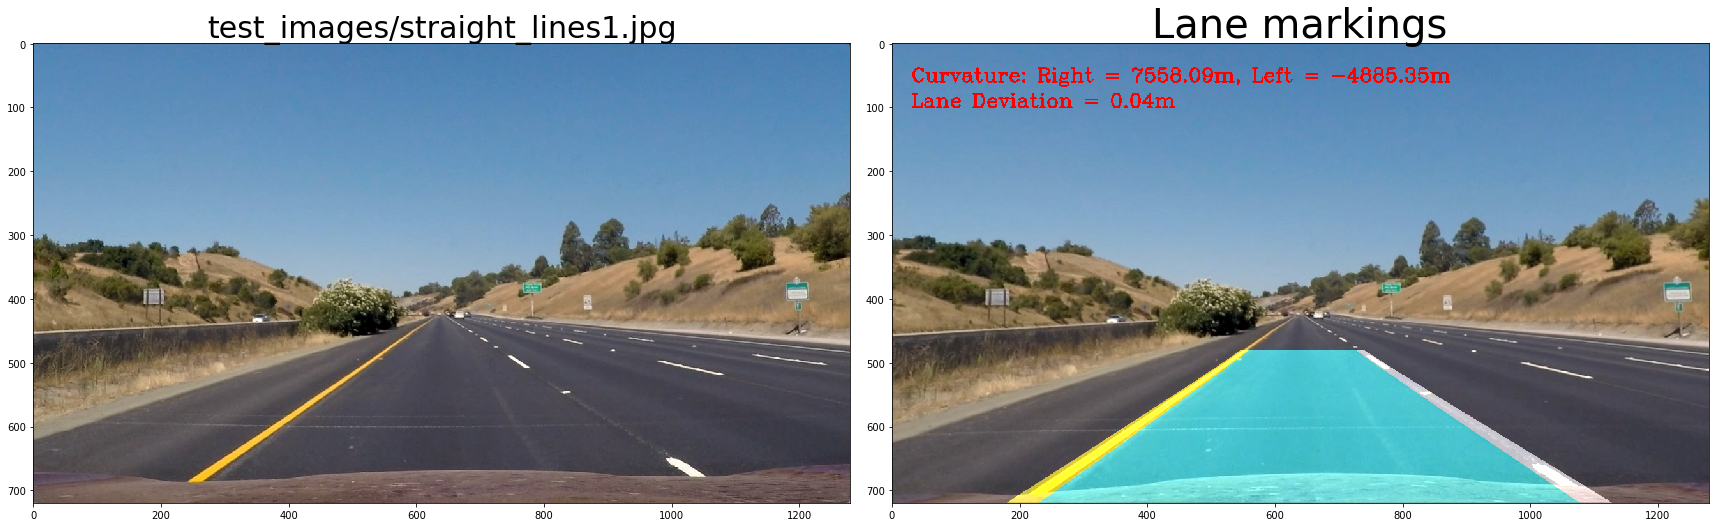

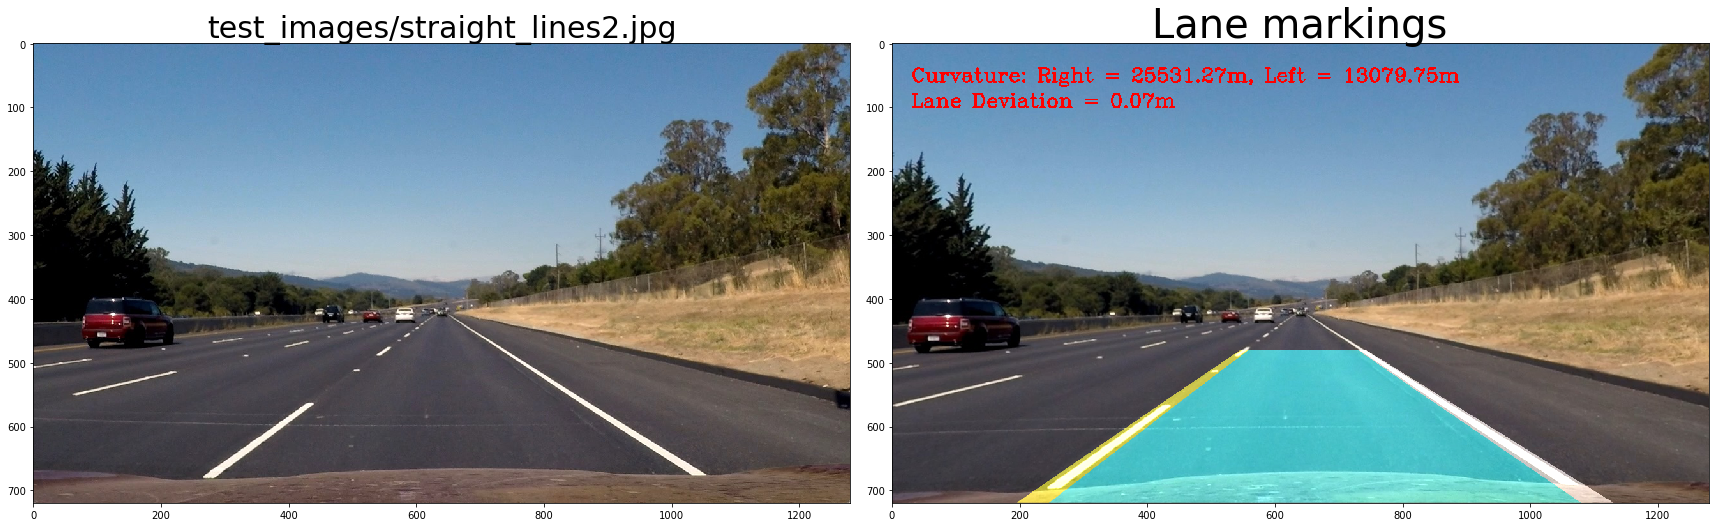

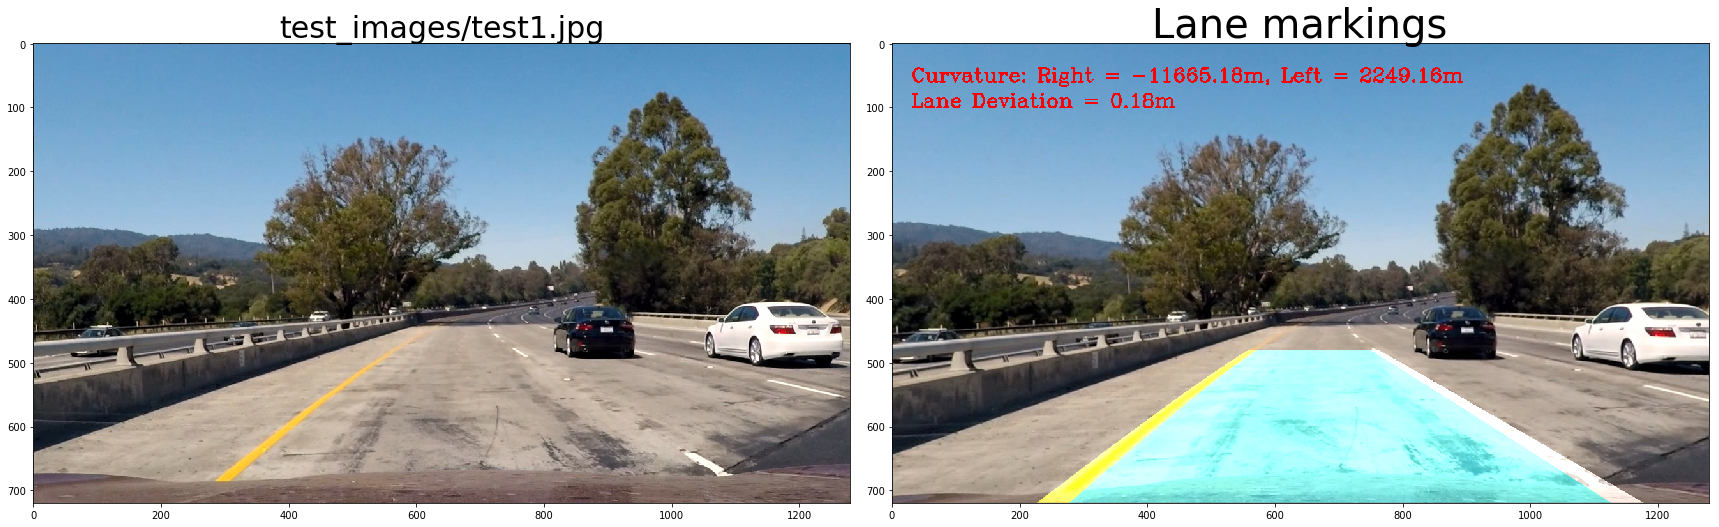

In [19]:
#Test final pipeline
img_files = ['test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg']


for img_file in img_files:
    print('Processing:', img_file)
    img = mpimg.imread(img_file) 
    result = pipeline(img)
    
    #Display the images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title(img_file, fontsize=30)

    ax2.imshow(result)
    ax2.set_title('Lane markings', fontsize=40)
    

In [17]:
"""
    VIDEO PIPELINE : The pipeline is almost similar for proecessing frames in a video.
                     One difference is that we exploit the temporal similarity of
                     frames in a video and make use of the peaks detected from previous
                     frame for processing current frame. This will speed up the processing.
"""

"""
    Prepare the mask for the next frame, based on current frame peak locations.
"""
def fill_masks_next_frame(img, left_poly_coeffs, right_poly_coeffs):
    img_patch_height = img.shape[0]/NUM_PATCHES
    left_mask = np.zeros_like(img)
    right_mask = np.zeros_like(img)
    
    for i in range(NUM_PATCHES):
        patch_bottom = int(img.shape[0]-(i*img_patch_height))
        patch_top = int(img.shape[0]-((i+1)*img_patch_height))
        pt_mid = (patch_top + patch_bottom)/2
        
        left_poly_pt = np.round(left_poly_coeffs[0]*pt_mid**2 + left_poly_coeffs[1]*pt_mid + left_poly_coeffs[2])
        right_poly_pt = np.round(right_poly_coeffs[0]*pt_mid**2 + right_poly_coeffs[1]*pt_mid + right_poly_coeffs[2])
                          
        left_mask[patch_top:patch_bottom, left_poly_pt-WINDOW_SIZE:left_poly_pt+WINDOW_SIZE] = 1.     
        right_mask[patch_top:patch_bottom, right_poly_pt-WINDOW_SIZE:right_poly_pt+WINDOW_SIZE] = 1. 
        
    return left_mask, right_mask   

"""
    Check the absolute difference between polynomial coefficients
    from two successive frames. If it is greater than a threshold,
    retain the coeffient values from the previous frame.
"""
def poly_coeffs_diff(poly, prev_poly):
    err_p = np.sum((poly[0]-prev_poly[0])**2) #/np.sum(right_fit_prev[0]**2)
    err_p = np.sqrt(err_p)
    
    if err_p>COEFFS_DIFFS:
        return 1
    else:
        return 0
    
"""
Checks the similarity between succesive polygons
"""
def check_poly_similarity(poly1, poly2):
    ret, thresh = cv2.threshold(poly1, 127, 255,0)
    ret, thresh2 = cv2.threshold(poly2, 127, 255,0)
    
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt1 = contours[0]
 
    im2, contours, hierarchy = cv2.findContours(thresh2,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt2 = contours[0]
    ret = cv2.matchShapes(cnt1,cnt2,1,0.0)
    
    return ret
    
"""
    FINAL PIPELINE FOR VIDEO
    This pipeline consists of camera calibration -> undistortion -> Binary_Threshold -> Perspective_transform ->
     -> Find lane lines -> Fit polynomial
"""

alpha = 0.05
def video_pipeline(img):
    global left_mask
    global right_mask
    global left_fit_coeffs_prev
    global right_fit_coeffs_prev
    global left_curve_rad_prev
    global right_curve_rad_prev
    global lane_offset_prev
    global first_frame
    global mtx
    global dist
    global prev_white_warp
    global prev_color_warp
    global frame_cnt
    
    if (DEBUG == 1):
        frame_cnt = frame_cnt + 1
        #if ((frame_cnt < 1000) or (frame_cnt > 1060)):
        #if ((frame_cnt < 15) or (frame_cnt > 35)):
        #str_curv = 'Frame num ' + str(frame_cnt) 
        #font = cv2.FONT_HERSHEY_COMPLEX    
        #cv2.putText(img, str_curv, (30, 150), font, 1, (255,0,0), 2)
        #return img 
    
    img_size = img.shape
    
    if (first_frame == 1):
        mtx, dist = fetch_cam_calib_params()
        
    result_1 = undistort_img(mtx, dist, img)
     
    result_2 = threshold_image(result_1)
    result_3 = region_of_interest(result_2)
    src_points, dst_points = get_perspective_cordinate_points(img_size)
    M, Minv = get_perspective_transform(src_points, dst_points)
    result_4 = apply_perspective_transform(M, result_3)
        
    if (first_frame == 1):
        left_mask, right_mask = find_lane_points(result_4)
    
    img_L = np.copy(result_4)
    img_L = cv2.bitwise_and(img_L,img_L,mask=left_mask)

    img_R = np.copy(result_4)
    img_R = cv2.bitwise_and(img_R,img_R,mask=right_mask)
    
    """
        Note: There is an assumption here that the first frame will be successfully 
              detected for lane lines.
    """
    left_fit_coeffs, right_fit_coeffs, status_l, status_r = fit_poly(result_4, img_L, img_R, 1, 1)
        
    if (status_l == -1):
        left_fit_coeffs  = left_fit_coeffs_prev
        left_str = [-111, -111, -111]
    else:
        left_str = left_fit_coeffs
    if (status_r == -1):
        right_fit_coeffs = right_fit_coeffs_prev
        right_str = [-111, -111, -111]
    else:
        right_str = right_fit_coeffs
    
    
    if (first_frame == 1):
        left_fit_coeffs_prev = left_fit_coeffs
        right_fit_coeffs_prev = right_fit_coeffs
        left_curve_rad_prev = 0
        right_curve_rad_prev = 0
        lane_offset_prev = 0
        #first_frame = 0
        
    left_diff = poly_coeffs_diff(left_fit_coeffs, left_fit_coeffs_prev) 
    if (left_diff == 1):
        print('left_coeffs differ', frame_cnt)
        left_fit_coeffs = left_fit_coeffs_prev
    else:
        left_fit_coeffs = alpha*left_fit_coeffs + (1-alpha)*left_fit_coeffs_prev
        
    right_diff = poly_coeffs_diff(right_fit_coeffs, right_fit_coeffs_prev) 
    if (right_diff == 1):
        print('right_coeffs differ', frame_cnt)
        right_fit_coeffs = right_fit_coeffs_prev
    else:
        right_fit_coeffs = alpha*right_fit_coeffs + (1-alpha)*right_fit_coeffs_prev
        
    
    left_y = np.arange(11)*img_size[0]/10
    left_fitx = left_fit_coeffs[0]*left_y**2 + left_fit_coeffs[1]*left_y + left_fit_coeffs[2]
    right_y = np.arange(11)*img_size[0]/10
    right_fitx = right_fit_coeffs[0]*right_y**2 + right_fit_coeffs[1]*right_y + right_fit_coeffs[2] 
        
    #Fill masks for the next frame. 
    left_mask, right_mask = fill_masks_next_frame(result_4, left_fit_coeffs, right_fit_coeffs)
    
    #Calculate radius of curvature
    YM_PER_PIX = HEIGHT_IN_MTS/img_size[0] # meters per pixel in y dimension
    XM_PER_PIX = WIDTH_IN_MTS/img_size[1] # meteres per pixel in x dimension
    left_fit_cr, right_fit_cr, status_l, status_r = fit_poly(result_4, img_L, img_R, XM_PER_PIX, YM_PER_PIX)
    if (status_l == -1):
        left_curve_rad  = left_curve_rad_prev
    else:
        pt = HEIGHT_IN_MTS
        left_curve_rad = get_radius_of_curvature(left_fit_cr, pt)
        
        
    if (status_r == -1):
        right_curve_rad = right_curve_rad_prev
    else:
        pt = HEIGHT_IN_MTS
        right_curve_rad = get_radius_of_curvature(right_fit_cr, pt)
        
    lane_offset = calc_lane_offset(img_size, left_fit_coeffs, right_fit_coeffs, XM_PER_PIX)
          
    
    warp_zero = np.zeros_like(result_4).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    white_warp = np.zeros_like(result_4).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))
    cv2.fillPoly(white_warp, np.int_([pts]), (255))

    col_L = (255,255,0)
    col_R = (255,255,255)    

    draw_pw_lines(color_warp,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp,np.int_(pts_right),col_R)

    
    image_ud = result_1
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    new_white_warp = cv2.warpPerspective(white_warp, Minv, (img.shape[1], img.shape[0])) 
    
    if (first_frame == 1):
        prev_white_warp = new_white_warp
        prev_color_warp = newwarp
        diff_shape = 0
        first_frame = 0
    else :
        diff_shape = check_poly_similarity(prev_white_warp, new_white_warp)
        if (diff_shape > SHAPE_THRESH):
            #newwarp = prev_color_warp
            print('diff shape')
        else:
            prev_white_warp = new_white_warp
            prev_color_warp = newwarp   
        
    left_fit_coeffs_prev = left_fit_coeffs
    right_fit_coeffs_prev = right_fit_coeffs
    
    result = cv2.addWeighted(image_ud, 1, newwarp, 0.5, 0)
    
    #Add radius of curvature text
    str_curv = 'Curvature: Right = ' + str(np.round(right_curve_rad,2)) + 'm, Left = ' + str(np.round(left_curve_rad,2)) + 'm'
    lane_dev = 'Lane Deviation = ' + str(np.round(lane_offset, 2)) + 'm'
    #diff_shape = 'shape_diff = ' + str(diff_shape)
    #str_frame_num = 'frame ' + str(frame_cnt)
    #left_coeff_str = 'lf: ' + str(left_str[0]) + '  ' + str(left_str[1]) + '  ' + str(left_str[2]) 
    #right_coeff_str = 'rt: ' + str(right_str[0]) + '  ' + str(right_str[1]) + '  ' + str(right_str[2])
    
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, str_curv, (30, 60), font, 1, (255,0,0), 2)
    cv2.putText(result, lane_dev, (30, 100), font, 1, (255,0,0), 2)
    #cv2.putText(result, diff_shape, (30, 140), font, 1, (255,0,0), 2)
    #cv2.putText(result, str_frame_num, (30, 170), font, 1, (255,0,0), 2)
    
    #cv2.putText(result, left_coeff_str, (30, 200), font, 1, (255,0,0), 2)
    #cv2.putText(result, right_coeff_str, (30, 230), font, 1, (255,0,0), 2)
    
        
    return result
    

In [18]:
"""
    TEST VIDEO PIPELINE
"""
from moviepy.editor import VideoFileClip
from IPython.display import HTML


frame_cnt = 0
first_frame = 1
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4");
white_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False);
print('Done')

Loading data from pickle file...
Data loaded from pickle file.
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 48%|████▊     | 611/1261 [02:51<03:26,  3.15it/s]

right_coeffs differ 0



 49%|████▊     | 612/1261 [02:52<03:24,  3.17it/s]

right_coeffs differ 0



 49%|████▊     | 613/1261 [02:52<03:23,  3.18it/s]

right_coeffs differ 0



 49%|████▊     | 614/1261 [02:52<03:23,  3.18it/s]

right_coeffs differ 0



 49%|████▉     | 615/1261 [02:52<03:25,  3.15it/s]

right_coeffs differ 0



 49%|████▉     | 616/1261 [02:53<03:25,  3.14it/s]

right_coeffs differ 0



 49%|████▉     | 621/1261 [02:54<03:23,  3.15it/s]

right_coeffs differ 0



 49%|████▉     | 622/1261 [02:55<03:28,  3.07it/s]

right_coeffs differ 0



 49%|████▉     | 623/1261 [02:55<03:26,  3.09it/s]

right_coeffs differ 0



 49%|████▉     | 624/1261 [02:55<03:25,  3.10it/s]

right_coeffs differ 0



 50%|████▉     | 625/1261 [02:56<03:22,  3.14it/s]

right_coeffs differ 0



 50%|████▉     | 626/1261 [02:56<03:20,  3.17it/s]

right_coeffs differ 0



 50%|████▉     | 627/1261 [02:56<03:21,  3.15it/s]

right_coeffs differ 0



 50%|████▉     | 629/1261 [02:57<03:23,  3.11it/s]

right_coeffs differ 0



 82%|████████▏ | 1037/1261 [05:35<01:26,  2.59it/s]

right_coeffs differ 0



 82%|████████▏ | 1038/1261 [05:35<01:26,  2.58it/s]

right_coeffs differ 0



 82%|████████▏ | 1039/1261 [05:36<01:27,  2.53it/s]

right_coeffs differ 0



 83%|████████▎ | 1041/1261 [05:37<01:30,  2.42it/s]

right_coeffs differ 0



 84%|████████▎ | 1053/1261 [05:42<01:27,  2.39it/s]

right_coeffs differ 0



100%|█████████▉| 1260/1261 [07:05<00:00,  2.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 10min 48s, sys: 3min 8s, total: 13min 56s
Wall time: 7min 6s
Done
